In [48]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

In [49]:
df = pd.read_csv("temperatura.csv")

### Pipeline de diferenciação até estacionariedade


In [50]:
def processar_coluna(df, col, signif=0.05, max_diff=5):
    serie_original = df[col].copy()
    serie_atual = serie_original.copy()
    diffs = 0

    # pipe de diferenciação até estacionariedade
    while diffs <= max_diff:
        adf_p = adfuller(serie_atual.dropna())[1]
        kpss_p = kpss(serie_atual.dropna(), regression="c")[1]
        is_stationary = adf_p < signif and kpss_p > signif

        print(f"[{col}] Dif={diffs} | ADF p={adf_p:.4f} | KPSS p={kpss_p:.4f} | Estacionária={is_stationary}")

        if is_stationary:
            print(f"[{col}] Série estacionária após {diffs} diferenciações\n")
            break

        serie_atual = serie_atual.diff().dropna()
        diffs += 1

    base = pd.DataFrame({
        f"{col}_stationary": serie_atual
    })

    # ajustar ar
    treino = serie_atual[:-1]
    modelo = AutoReg(treino, lags=1, old_names=False).fit()
    previsoes = modelo.predict(start=0, end=len(serie_atual)-1)

    base[f"{col}_AR1"] = previsoes.values

    # plotando antes e depois da diferencciacao
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(serie_original, color="darkviolet", label="Original")
    plt.title(f"{col} - Original")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(serie_atual, color="deeppink", label="Após diferenciação")
    plt.title(f"{col} - Após {diffs} diferenciações")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # plotando estacionaria x ar
    plt.figure(figsize=(12, 5))
    plt.plot(base[f"{col}_stationary"], label=f"{col} estacionária", color="deeppink")
    plt.plot(base[f"{col}_AR1"], label="AR", color="gold")
    plt.title(f"{col} - Estacionária vs AR")
    plt.legend()
    plt.show()

    return base


[Temp_C] Dif=0 | ADF p=0.0171 | KPSS p=0.0100 | Estacionária=False
[Temp_C] Dif=1 | ADF p=0.0000 | KPSS p=0.1000 | Estacionária=True
[Temp_C] Série estacionária após 1 diferenciações



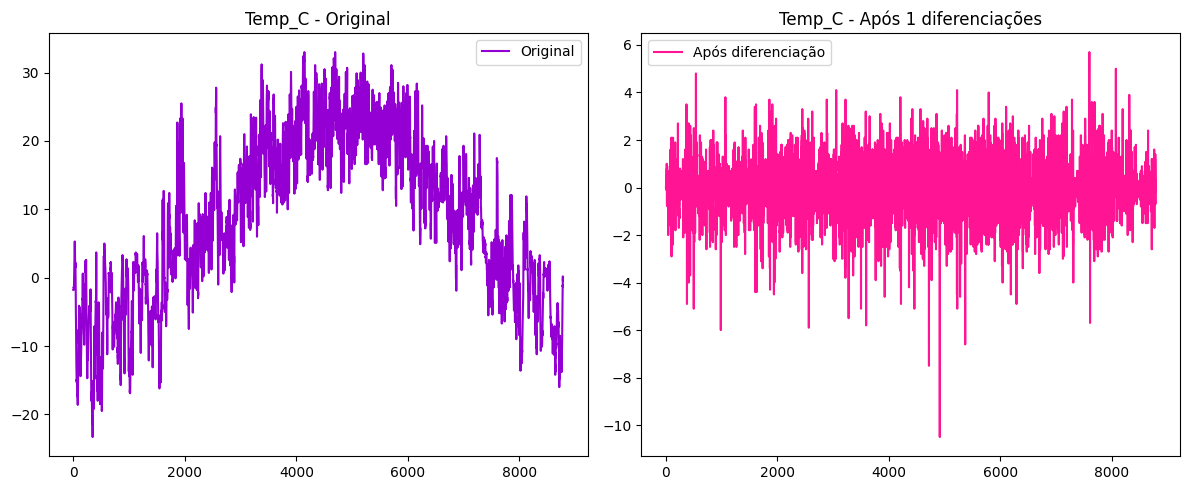

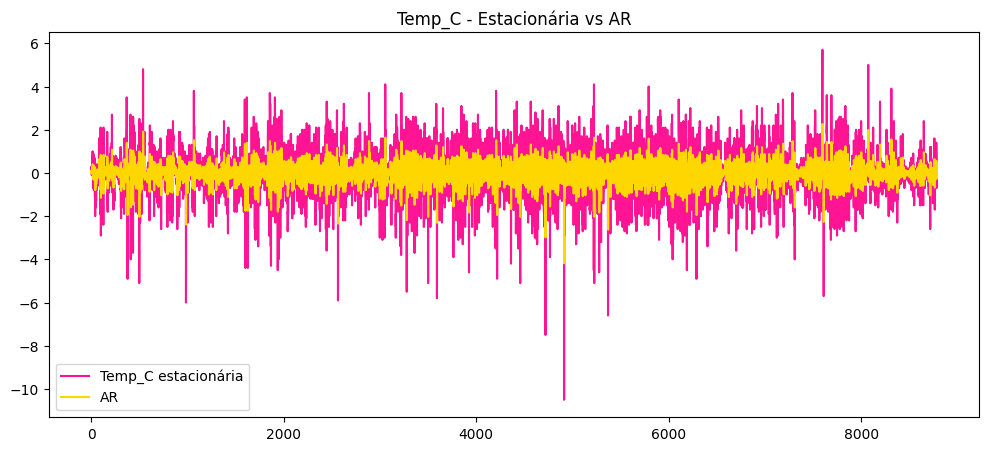

[Dew Point Temp_C] Dif=0 | ADF p=0.0001 | KPSS p=0.0100 | Estacionária=False
[Dew Point Temp_C] Dif=1 | ADF p=0.0000 | KPSS p=0.1000 | Estacionária=True
[Dew Point Temp_C] Série estacionária após 1 diferenciações



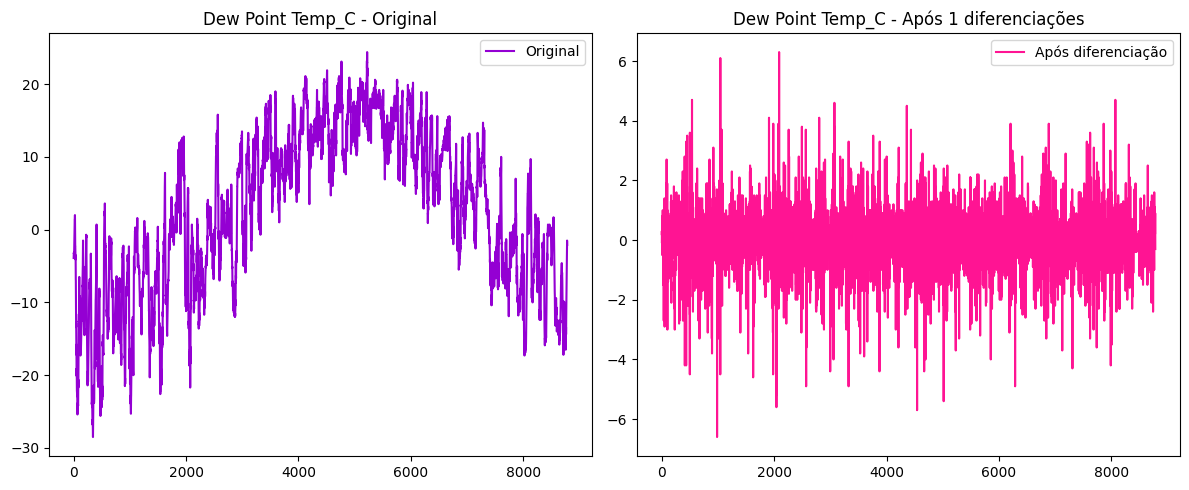

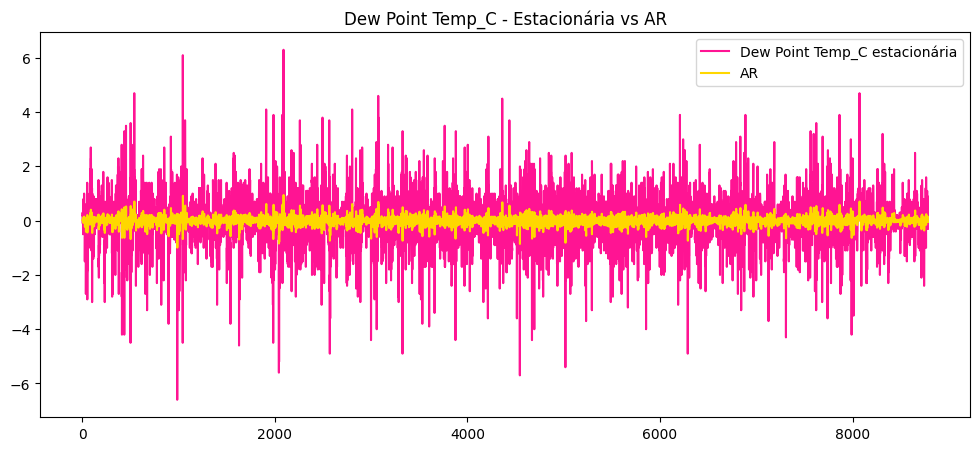

Base Temp_C:
   Temp_C_stationary  Temp_C_AR1
1                0.0         NaN
2                0.0    0.000123
3                0.3    0.000123
4                0.0    0.119571
5                0.1    0.000123

Base Dew Point Temp_C:
   Dew Point Temp_C_stationary  Dew Point Temp_C_AR1
1                          0.2                   NaN
2                          0.3              0.030226
3                          0.2              0.045251
4                         -0.1              0.030226
5                          0.0             -0.014850


In [51]:
base_temp = processar_coluna(df, "Temp_C")
base_dew = processar_coluna(df, "Dew Point Temp_C")

print("Base Temp_C:")
print(base_temp.head())

print("\nBase Dew Point Temp_C:")
print(base_dew.head())